# Garment Industry Employee Productivity

Tijesunimi Odebode

04/02/2022

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import necessary packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#Importing the KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
# Import random forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
#import accuracy, precision, recall, classification report, and confusion matrix scoring functions
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## 2. Load and verify data

In [4]:
filename = '/content/drive/MyDrive/Coding Dojo Bootcamp/Data/garments_worker_productivity.xlsx'
garm_prod = pd.read_excel(filename)
garm_prod.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


## 3. Explore the data

### a) Check for missing values. 
- Missing values will not be addressed here. Missing values will be addressed further down in the notebook. However, let's check to see the missing values.

In [5]:
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    691 non-null    float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

- There are 1197 rows and 15 columns. There is missing data in the **'wip'** column considering there are only 691 non-null values.

### b) Explore the 'date' column to determine how to split it in preparation for modeling

In [6]:
# Check the unique values in the 'date' column
garm_prod['date'].value_counts()

2015-03-11    24
2015-01-31    24
2015-01-11    23
2015-03-10    23
2015-01-12    23
2015-01-24    23
2015-01-08    22
2015-01-10    22
2015-01-07    22
2015-01-13    22
2015-01-05    22
2015-03-09    22
2015-03-08    22
2015-03-03    22
2015-01-22    22
2015-02-25    21
2015-02-26    21
2015-02-28    21
2015-01-03    21
2015-01-04    21
2015-01-28    21
2015-01-27    21
2015-03-04    21
2015-01-25    21
2015-01-17    21
2015-01-14    21
2015-01-06    21
2015-02-18    21
2015-01-29    20
2015-02-17    20
2015-03-02    20
2015-03-01    20
2015-02-22    20
2015-02-19    20
2015-03-05    19
2015-03-07    19
2015-02-24    19
2015-02-23    19
2015-01-01    19
2015-02-03    19
2015-02-15    19
2015-01-15    19
2015-01-18    19
2015-01-19    19
2015-01-21    19
2015-01-26    19
2015-02-01    19
2015-02-02    19
2015-02-04    19
2015-02-07    19
2015-02-08    19
2015-02-10    19
2015-02-11    19
2015-02-12    19
2015-02-05    18
2015-02-09    18
2015-02-16    18
2015-02-14    17
2015-01-20    

- From the above, it looks like the evaluation of employees was done in the same year. As a result, we only have to split the 'date' columns into 2 columns (month and day).

### c) Create a new column for the months listed in the 'date' column. The new column will be titled '**month**.'

In [7]:
garm_prod['month'] = garm_prod['date'].dt.month
garm_prod['month'] 

0       1
1       1
2       1
3       1
4       1
       ..
1192    3
1193    3
1194    3
1195    3
1196    3
Name: month, Length: 1197, dtype: int64

### d) Create a new column for the numerical days listed in the 'date' column. The new column will be titled '**daynum**.'

In [8]:
garm_prod['daynum'] = garm_prod['date'].dt.day
garm_prod['daynum'] 

0        1
1        1
2        1
3        1
4        1
        ..
1192    11
1193    11
1194    11
1195    11
1196    11
Name: daynum, Length: 1197, dtype: int64

### e) Drop the 'date' column and confirm that our dataset now has the new columns we just added

In [9]:
# Drop the 'date' column
garm_prod.drop(columns=['date'], inplace=True)
# Confirm that the dataset now has the new columns added
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
 14  month                  1197 non-null   int64  
 15  dayn

- We now have 16 columns, confirming that the 'date' column has been dropped and two new columns have been added. Also, we can see the new columns in the dataset information above.

### f. Make sure the 'month' and 'daynum' columns are 'object' datatype so they can be one-hot encoded later.

In [10]:
garm_prod['month'] = garm_prod['month'].astype('object')
garm_prod['daynum'] = garm_prod['daynum'].astype('object')
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
 14  month                  1197 non-null   object 
 15  dayn

### g. Make sure the 'team' column is 'object' datatype so it can be one-hot encoded later.

In [11]:
garm_prod['team'] = garm_prod['team'].astype('object')
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   object 
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
 14  month                  1197 non-null   object 
 15  dayn

### h) Check for duplicates and address them

In [12]:
# Identify and address any duplicates
garm_prod.duplicated().sum()

0

- There are no duplicates in the dataset

### i) Let's check the datatypes and ensure they are all correct

In [13]:
gpdata_types = garm_prod.dtypes
gpdata_types

quarter                   object
department                object
day                       object
team                      object
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
month                     object
daynum                    object
dtype: object

- All the datatypes seeem to be correct.

### j) Check for other errors/issues with the data and fix them

In [14]:
# Let's check the statistics for the numerical columns
garm_prod.describe()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


- It looks like the 'actual_productivity' column has a maximum value of approximately 1.120. Based on the attribute information given on the dataset reference page (https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees#), 'actual_productivity' should range between 0 and 1. 

Let's check how many rows contain a value greater than 1 in the 'actual_productivity' column.

In [15]:
# Let's see how many rows contain actual_productivity > 1
prod_filter = garm_prod['actual_productivity']>1
prod_filter.sum()

37

In [16]:
# Let's create a filter for actual_productivity < or = 1 
# This should delete rows with actual_productivity > 1
prod1_filter = garm_prod['actual_productivity'] <= 1
garm_prod = garm_prod.loc[prod1_filter, :]

In [17]:
# Let's confirm that rows with actual_productivity > 1 have been dropped
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1160 non-null   object 
 1   department             1160 non-null   object 
 2   day                    1160 non-null   object 
 3   team                   1160 non-null   object 
 4   targeted_productivity  1160 non-null   float64
 5   smv                    1160 non-null   float64
 6   wip                    666 non-null    float64
 7   over_time              1160 non-null   int64  
 8   incentive              1160 non-null   int64  
 9   idle_time              1160 non-null   float64
 10  idle_men               1160 non-null   int64  
 11  no_of_style_change     1160 non-null   int64  
 12  no_of_workers          1160 non-null   float64
 13  actual_productivity    1160 non-null   float64
 14  month                  1160 non-null   object 
 15  dayn

- We now have 1160 rows instead of 1197 previously. This confirms that 37 rows have been dropped.

## 4) Identify each feature as numerical, ordinal, or nominal.

**Numerical features:** 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'

**Nominal features:** 'quarter', 'department', 'day', 'team'

**Ordinal features:** There are no ordinal features

## 5) Find and Fix inconsistent categories of data in the nominal feature columns

In [18]:
# Let's assign a variable to columns that are just 'object' datatypes
obj_col = gpdata_types[gpdata_types=='object'].index
obj_col

Index(['quarter', 'department', 'day', 'team', 'month', 'daynum'], dtype='object')

In [19]:
# Let's loop through 'object' columns and see the unique values and counts in all 'object' columns
for x in obj_col:
    print(f'- {x}:')
    print(garm_prod[x].value_counts(dropna=False))
    print()

- quarter:
Quarter1    348
Quarter2    324
Quarter4    243
Quarter3    204
Quarter5     41
Name: quarter, dtype: int64

- department:
sweing        666
finishing     253
finishing     241
Name: department, dtype: int64

- day:
Wednesday    200
Sunday       196
Monday       195
Tuesday      194
Thursday     193
Saturday     182
Name: day, dtype: int64

- team:
8     108
9     104
4     103
10    100
12     97
7      96
1      94
6      94
2      94
5      92
3      90
11     88
Name: team, dtype: int64

- month:
1    533
2    415
3    212
Name: month, dtype: int64

- daynum:
10    63
8     62
11    62
3     60
4     59
7     58
5     57
1     55
22    42
25    42
24    42
28    40
17    40
18    40
9     39
26    39
19    39
12    39
2     38
14    37
15    35
13    22
31    22
6     21
21    19
27    19
29    19
23    19
16    17
20    14
Name: daynum, dtype: int64



- We can see from the above that

a) There are no inconsistent categories of data in the 'quarter' column.

b) There are no inconsistent categories of data in the 'day' column.

c) There are no inconsistent categories of data in the 'month' column.

d) There are no inconsistent categories of data in the 'daynum' column.

e) In the 'department' column, it seems like there are two unique ways the word 'finishing' appears. However, it is not exactly obvious why this is so. Both words seem to be spelt correctly and the same way. 

Let's see the unique values a different way.

In [20]:
# Let's see the unique values in the 'department' column
garm_prod['department'].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

- It is obvious from the above that in one case, 'finishing' is written with a white space after the word. So, the word appears in two ways: 'finishing ' and 'finishing'.


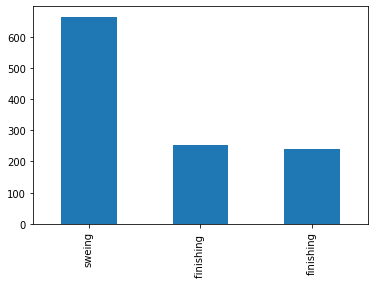

In [21]:
# Let's see the unique values in the 'department' column in a bar chart
garm_prod['department'].value_counts().plot(kind = 'bar');

In [22]:
# We can make 'finishing ' appear as 'finishing'
garm_prod['department'] = garm_prod['department'].replace('finishing ','finishing')
dept_replace = garm_prod['department'].unique()
dept_replace.sort()
dept_replace

array(['finishing', 'sweing'], dtype=object)

- All inconsistent 'finishing' have been corrected

In [23]:
# Let's run value_counts also to confirm
garm_prod['department'].value_counts()

sweing       666
finishing    494
Name: department, dtype: int64

- We now have a total count of 494 (253 + 241) for the word 'finishing'

In [24]:
# We can make 'sweing' appear as 'sewing'
garm_prod['department'] = garm_prod['department'].replace('sweing','sewing')
dept_replace = garm_prod['department'].unique()
dept_replace.sort()
dept_replace

array(['finishing', 'sewing'], dtype=object)

## 6) Identify Outliers

In [25]:
# Let's check the statistics for the numerical columns
garm_prod.describe()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1160.000000,1160.00000,666.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000
mean,0.727905,15.01481,1159.974474,4575.301724,37.012931,0.753448,0.381034,0.155172,34.346552,0.725991
std,0.098735,11.00475,1769.132478,3363.475857,162.300882,12.910356,3.320081,0.433766,22.181174,0.169404
min,0.070000,2.90000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,0.700000,3.94000,762.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650061
50%,0.750000,15.26000,1028.500000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.754425
75%,0.800000,24.26000,1226.750000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.845167
max,0.800000,54.56000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,0.999995


- To determine the outliers in our data, I would have to use a data visualization technique. I have decided to use boxplots. First, I will look at the above summary statistics (found using '.describe'), and then look at the median of each column to see if it is halfway in the middle of all the values. If the median is around halfway of all the values, then there is a chance that column does not have an outlier. Secondly, if the maximum is far away from the 75% (75th percentile) value, there is a chance that column has an outlier. Finally, if the minimum is far away from the 25% (25th percentile) value, there is a chance that column has an outlier. I have selected columns after considering the above 3 criteria stated and decided to create boxplots for each of those columns below.

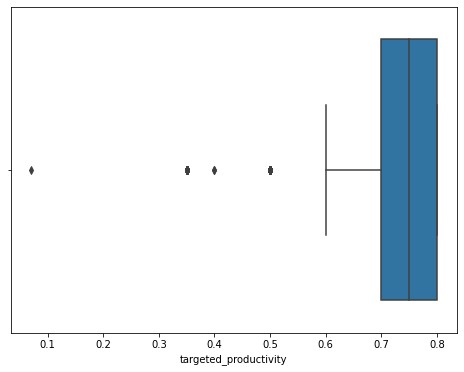

In [26]:
# Boxplot for 'targeted_productivity' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='targeted_productivity');

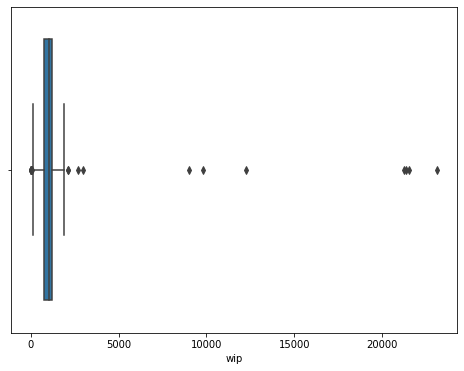

In [27]:
# Boxplot for 'wip' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='wip');

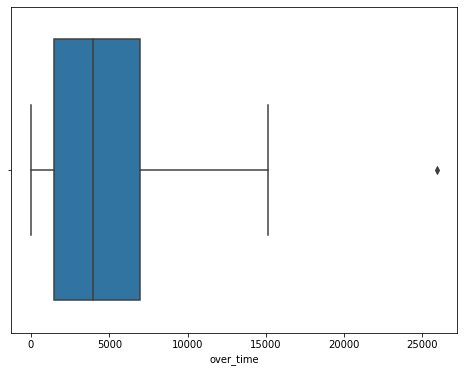

In [28]:
# Boxplot for 'over_time' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='over_time');

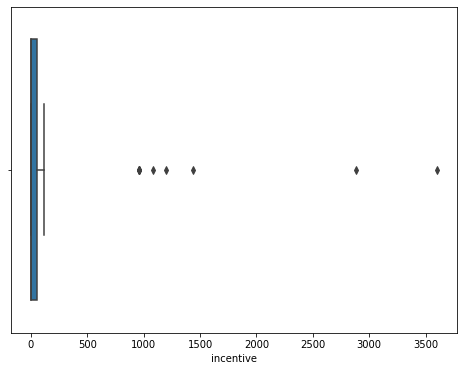

In [29]:
# Boxplot for 'incentive' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='incentive');

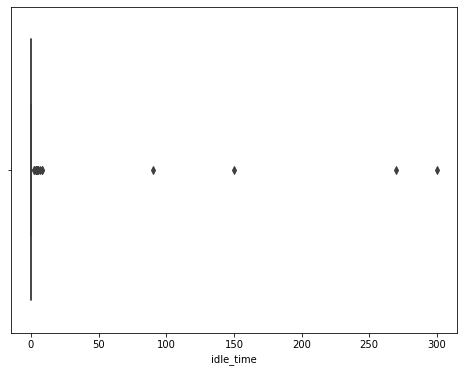

In [30]:
# Boxplot for 'idle_time' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='idle_time');

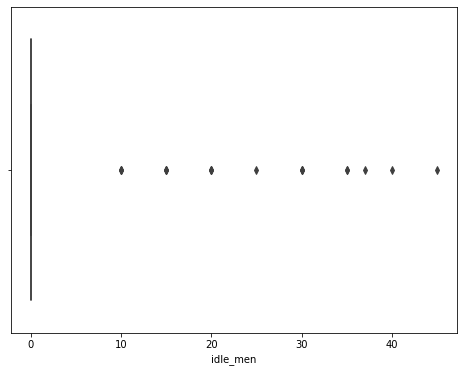

In [31]:
# Boxplot for 'idle_men' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='idle_men');

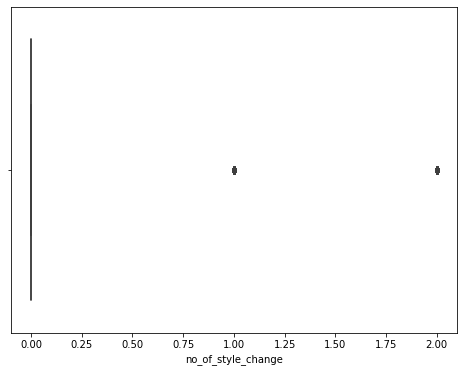

In [32]:
# Boxplot for 'no_of_style_change' column
plt.figure(figsize=(8,6))
sns.boxplot(data=garm_prod, x='no_of_style_change');

- We can see from the above boxplots that the following columns have outliers in them: 'targeted_productivity', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', and 'no_of_style_change'

- I have decided to keep the outliers in the 'garm_prod' data because I see no reason to believe they are errors in the dataset.

## 7) Create univariate and multivariate visualizations. 

a) Barchart of 'department' column. We will plot the count of each department

b) Compare actual productivity for each department 

c) Compare actual productivity for each department for each day of the week.

d) Histogram of 'targeted_productivity' column. The 'targeted_productivity' column represents targeted productivity set by the authority for each team for each day.

e) Histogram of 'actual_productivity' column. The 'actual_productivity' column represents the actual % of productivity that was delivered by the workers. 

f) Compare the 'incentive' and 'actual_productivity' columns

### a) Barchart of 'department' column. 

In [33]:
# Count each department listed in the 'department' column
dept_counts = garm_prod['department'].value_counts()
dept_counts

sewing       666
finishing    494
Name: department, dtype: int64

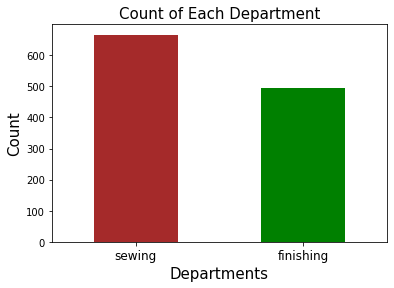

sewing       666
finishing    494
Name: department, dtype: int64

In [34]:
# Plot the counts of each department

dept_counts.plot(kind = 'bar', color = ['brown','green'])
plt.title('Count of Each Department', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Departments', fontsize = 15)
plt.xticks(rotation = 0, fontsize = 12)

# Show your figure
plt.show()

# Display the counts below the plot
dept_counts

- We can see from the above bar chart that the department 'sweing' had a higher count. There was more data obtained from the sweing department than the finishing department.

### b) Compare actual productivity for each department 

Text(0.5, 1.0, 'Actual productivity for each Department')

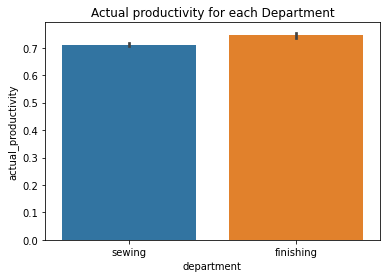

In [35]:
ax = sns.barplot(data=garm_prod, x = 'department', y = 'actual_productivity', ci = 68)
ax.set_title('Actual productivity for each Department')

### c) Compare actual productivity for each department for each day of the week

In [36]:
garm_prod['day'].unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

Text(0.5, 1.0, 'Actual productivity for each Department per weekday')

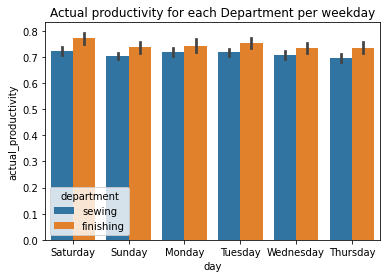

In [37]:
order = ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday']
ax=sns.barplot(data=garm_prod, x = 'day', y = 'actual_productivity', hue = 'department', ci = 68, order = order)
ax.set_title('Actual productivity for each Department per weekday')

- For both departments, it looks like actual productivity is highest on Saturdays. It also looks like actual productvity was higher for the finishing department than the sweing department each day. 

### d) Histogram of 'targeted_productivity' column. 

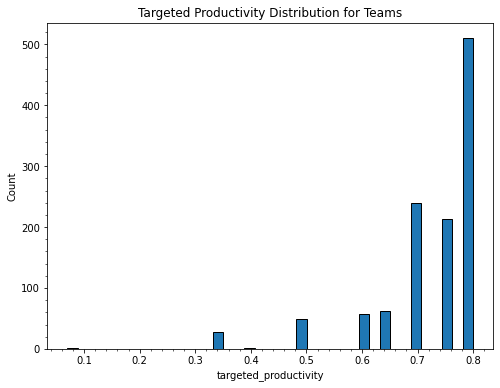

In [38]:
# Histogram of Targeted Productivity distribution.
plt.figure(figsize=(8,6))
# Parameter "edgecolor='black'" was adapted from: https://www.youtube.com/watch?v=XDv6T4a0RNc&list=PL-osiE80TeTvipOqomVEeZ1HRrcEvtZB_&index=6
plt.hist(garm_prod['targeted_productivity'], bins='auto', edgecolor='black')
plt.xlabel("targeted_productivity")
plt.ylabel("Count")
plt.title("Targeted Productivity Distribution for Teams")
# "The following Code adapted from: https://stackoverflow.com/questions/9127434/how-to-create-major-and-minor-gridlines-with-different-linestyles-in-python”
plt.minorticks_on();

- From the above histogram, targeted productivity frequency for workers was highest around approximately 0.78 - 0.80 or 78% - 80% range. This means that the number of times work teams were given set target productivity between 78% - 80% range was highest of all target productivity ranges. Since this range is the highest of all, we can say that employers expected high productivity from workers most days.

### e) Histogram of 'actual_productivity' column.

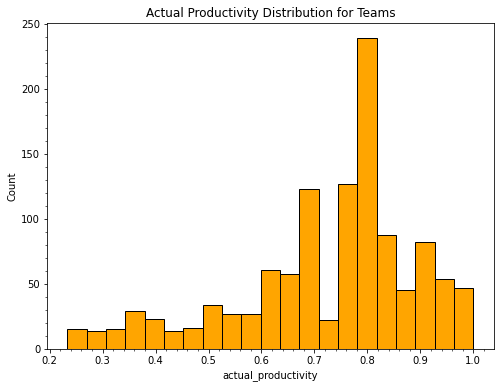

In [39]:
# Histogram of Targeted Productivity distribution.
plt.figure(figsize=(8,6))
plt.hist(garm_prod['actual_productivity'], color = 'orange', bins='auto', edgecolor='black')
plt.xlabel("actual_productivity")
plt.ylabel("Count")
plt.title("Actual Productivity Distribution for Teams")
plt.minorticks_on();

- From the above histogram, actual productivity frequency for workers was highest around approximately 0.78 - 0.82 or 78% - 82% range. This means that the number of times actual percent productivity for work teams fell between 78% - 82% range was highest of all actual productivity ranges. Since this range is close to the target productivity range (78% - 80%) with highest frequency, we can say that the target productivity was met by work teams most of the time.

### f) Compare the 'incentive' and 'actual_productivity' columns

In [40]:
# Compare the 'incentive' and 'actual_productivity' columns
# plt.scatter(garm_prod['incentive'], garm_prod['actual_productivity'])
# plt.title('Incentive and Actual Productivity Correlation')
# plt.xlabel('incentive')
# plt.ylabel('actual_productivity')

- From the above graph, we can see that majority of the teams had incentive of 0 BDT. Also, we see that there are some outliers in the data set.

Let's try removing the outliers and the 0 incentives to see if there is any correlation between incentive and actual productivity.

In [41]:
# sns.regplot(data=garm_prod, x = 'incentive', y = 'actual_productivity')

In [42]:
# Let's create a filter for actual_productivity < or = 1 
# This should delete rows with actual_productivity > 1
# inc_filter = garm_prod['incentive'] > 0 
# inc_filter
# garm_prod = garm_prod.loc[inc_filter, :]
# inc500_filter = garm_prod['incentive'] < 500
# garm_prod = garm_prod.loc[inc500_filter, :]

In [43]:
# Compare the 'incentive' and 'actual_productivity' columns
# plt.scatter(garm_prod['incentive'], garm_prod['actual_productivity'])
# plt.title('Correlation Between Incentive and Actual Productivity')
# plt.xlabel('Incentive')
# plt.ylabel('Actual Productivity')

In [44]:
# ax = sns.regplot(data=garm_prod, x = 'incentive', y = 'actual_productivity')
# ax.set_title('Incentive and Actual Productivity Correlation (no outliers or zeros)')

## 8) Classify actual_productivity column into two classes 'Yes' and 'No' based on employee teams that met their targeted productivity

- In the dataset, there is a column titled 'targeted_productivity.' This column represents the targeted productivity (a number between 0 and 1) set by the Authority for each team for each day.

- We will create a new column titled 'met_goal' for employee teams that met their target productivity goal

- We will also drop the 'actual_productivity' column.

In [45]:
garm_prod['met_goal'] = garm_prod['actual_productivity'] >= garm_prod['targeted_productivity']
garm_prod['met_goal'].replace({True: 'Yes', False: 'No'}, inplace=True)
garm_prod['met_goal'].value_counts()

Yes    838
No     322
Name: met_goal, dtype: int64

Text(0.5, 1.0, 'Number of teams that met productivity goals per weekday')

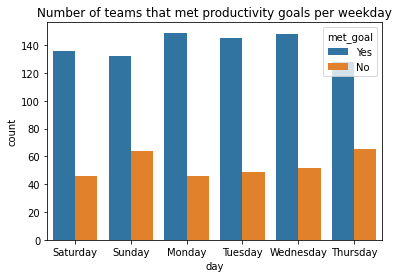

In [46]:
ax = sns.countplot(data=garm_prod, x = 'day', hue = 'met_goal', order = order)
ax.set_title('Number of teams that met productivity goals per weekday')

In [47]:
# Drop 'actual_productivity' column
garm_prod.drop(columns=['actual_productivity'], inplace=True)
garm_prod.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,month,daynum,met_goal
0,Quarter1,sewing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,1,1,Yes
1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,1,1,Yes
2,Quarter1,sewing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,1,1,Yes
3,Quarter1,sewing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,1,1,Yes
4,Quarter1,sewing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,1,1,Yes


- As seen in the table above, the 'actual productivity' column has been dropped and a new column titled 'met_goal' has been created

## 8) Correlation heatmap of the 'garm_prod' dataframe

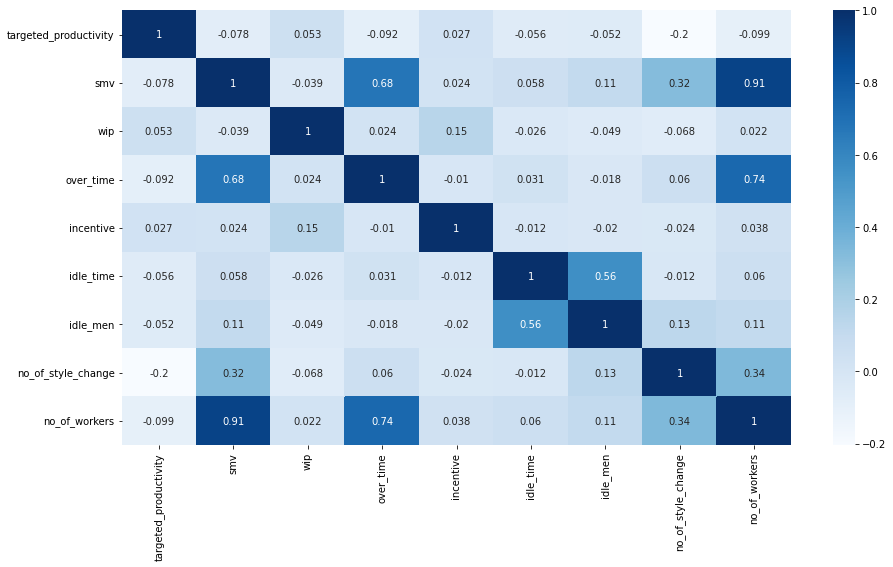

In [48]:
# Heat map of the 'garm_prod' dataframe
corr = garm_prod.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, cmap='Blues', annot=True);

- Low positive correlation coefficients are roughly between 0.3 and 0.5. Low negative correlation coefficients are roughly between -0.3 and -0.5.

- Moderate positive correlation coefficients are between 0.5 and 0.7. Moderate negative correlation coefficients are roughly between -0.5 and -0.7.

- Strong correlation coefficients are between 0.7 and 1. Strong negative correlation coefficients are between -0.7 and -1.

- In general, the closer the correlation coefficient is to 0, the weaker the correlation.

- The following are the moderate and strong correlations in the data:

**Moderate positive Correlations:**

- 'smv' and 'over_time': Correlation Coefficient is 0.68  

- 'over_time' and 'no_of_workers': Correlation Coefficient is 0.74

- 'idle_time' and 'idle_men': Correlation Coefficient is 0.56

**Strong positive Correlations:**

- 'smv' and 'no_of_workers': Correlation Coefficient is 0.91

There are no moderate or strong negative correlations


## 9) Identify features as numerical, ordinal, or nominal based on updates to the dataset.

In [49]:
garm_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 0 to 1196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1160 non-null   object 
 1   department             1160 non-null   object 
 2   day                    1160 non-null   object 
 3   team                   1160 non-null   object 
 4   targeted_productivity  1160 non-null   float64
 5   smv                    1160 non-null   float64
 6   wip                    666 non-null    float64
 7   over_time              1160 non-null   int64  
 8   incentive              1160 non-null   int64  
 9   idle_time              1160 non-null   float64
 10  idle_men               1160 non-null   int64  
 11  no_of_style_change     1160 non-null   int64  
 12  no_of_workers          1160 non-null   float64
 13  month                  1160 non-null   object 
 14  daynum                 1160 non-null   object 
 15  met_

**Numerical features:** 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers'

**Nominal features:** 'quarter', 'department', 'day', 'month', 'daynum', 'team'

**Ordinal features:** There are no ordinal features

## 10) Check target (met_goal) class balance

In [50]:
# Check class balance numbers
garm_prod['met_goal'].value_counts()

Yes    838
No     322
Name: met_goal, dtype: int64

In [51]:
# Check class balance percentages
garm_prod['met_goal'].value_counts(normalize=True)

Yes    0.722414
No     0.277586
Name: met_goal, dtype: float64

## 11) Validation Split

In [52]:
X = garm_prod.drop(columns=['met_goal'])
y = garm_prod['met_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## 12) Instantiate Column Selectors

In [53]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

## 13) Instantiate Transformers.

We will be using 3 different transformers: SimpleImputer, StandardScaler, and OneHotEncoder. There will be one SimpleImputer with one imputation strategy: ‘median’ strategy for numeric columns. There is no categorical feature with missing value, so we won't need to use SimpleImputer for categorical columns. We will one-hot encode the nominal categorical features as well.

In [54]:
# Imputers
median_imputer = SimpleImputer(strategy='median')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

## 14) Instantiate Pipelines

We will be using ONE pipeline for numeric data.

In [55]:
# Numeric pipeline
numeric_pipe = make_pipeline(median_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

## 15) Instantiate ColumnTransformer

In [56]:
# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (ohe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12c610>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12cc50>)])

- We only one-hot encode nominal features. The cat_selector selects nominal categorical features before they are one-hot encoded in this section. We did not have ordinal features. If we did, we would have ordinal encoded the ordinal features. Ordinal features are ordered categorical features. Nominal features are unordered categorical features. Since computational modeling can only model numbers, we need to convert categorical data to numeric form by ordinal encoding ordinal features and one-hot encoding nominal features.

## 16) Fit the ColumnTransformer on the training data and transform both training and testing data

In [57]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12c610>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12cc50>)])

In [58]:
# transform training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## 17) Inspect the Result

In [59]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (870, 67)




array([[ 0.22079175, -0.9915077 , -0.04641955, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22079175, -0.9724977 , -0.04641955, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.71637696,  0.69042539,  0.46119394, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.27479345,  0.10926228, -0.1058853 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.27479345,  0.35277143,  0.48360132, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22079175,  0.35277143,  0.14404324, ...,  0.        ,
         0.        ,  0.        ]])

- From the above, we see that there are no missing data, all data are of type float64, and there are 56 columns.

## 18) Inspect Result in a dataframe with column names

In [60]:
# Let's get out the column transformer steps
preprocessor.named_transformers_

{'onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())])}

In [61]:
# Reference the one hot encoder
cat_hot = preprocessor.named_transformers_['onehotencoder']

In [62]:
# Extract the feature names out from the one hot encoder
cat_feature_names = cat_hot.get_feature_names_out(cat_selector(X_train))
cat_feature_names 

array(['quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing',
       'department_sewing', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday', 'team_1', 'team_2',
       'team_3', 'team_4', 'team_5', 'team_6', 'team_7', 'team_8',
       'team_9', 'team_10', 'team_11', 'team_12', 'month_1', 'month_2',
       'month_3', 'daynum_1', 'daynum_2', 'daynum_3', 'daynum_4',
       'daynum_5', 'daynum_6', 'daynum_7', 'daynum_8', 'daynum_9',
       'daynum_10', 'daynum_11', 'daynum_12', 'daynum_13', 'daynum_14',
       'daynum_15', 'daynum_16', 'daynum_17', 'daynum_18', 'daynum_19',
       'daynum_20', 'daynum_21', 'daynum_22', 'daynum_23', 'daynum_24',
       'daynum_25', 'daynum_26', 'daynum_27', 'daynum_28', 'daynum_29',
       'daynum_31'], dtype=object)

In [63]:
# Get the final column names which are numerical features + categorical features
final_columns = num_selector(X_train) + list(cat_feature_names)
final_columns

['targeted_productivity',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_style_change',
 'no_of_workers',
 'quarter_Quarter1',
 'quarter_Quarter2',
 'quarter_Quarter3',
 'quarter_Quarter4',
 'quarter_Quarter5',
 'department_finishing',
 'department_sewing',
 'day_Monday',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday',
 'team_1',
 'team_2',
 'team_3',
 'team_4',
 'team_5',
 'team_6',
 'team_7',
 'team_8',
 'team_9',
 'team_10',
 'team_11',
 'team_12',
 'month_1',
 'month_2',
 'month_3',
 'daynum_1',
 'daynum_2',
 'daynum_3',
 'daynum_4',
 'daynum_5',
 'daynum_6',
 'daynum_7',
 'daynum_8',
 'daynum_9',
 'daynum_10',
 'daynum_11',
 'daynum_12',
 'daynum_13',
 'daynum_14',
 'daynum_15',
 'daynum_16',
 'daynum_17',
 'daynum_18',
 'daynum_19',
 'daynum_20',
 'daynum_21',
 'daynum_22',
 'daynum_23',
 'daynum_24',
 'daynum_25',
 'daynum_26',
 'daynum_27',
 'daynum_28',
 'daynum_29',
 'daynum_31']

In [64]:
# Change the X_train and X_test transformed columns to a dataframe
X_train_df = pd.DataFrame(X_train_processed, columns = final_columns)
X_test_df = pd.DataFrame(X_test_processed, columns = final_columns)

In [65]:
# View the first five rows of the X_train transformed dataframe

X_train_df.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,quarter_Quarter1,...,daynum_21,daynum_22,daynum_23,daynum_24,daynum_25,daynum_26,daynum_27,daynum_28,daynum_29,daynum_31
0,0.220792,-0.991508,-0.046420,-1.062218,-0.233135,-0.050096,-0.110077,-0.354952,-1.174334,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.220792,-0.972498,-0.046420,-1.277495,-0.233135,-0.050096,-0.110077,-0.354952,-1.445149,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.716377,0.690425,0.461194,0.677942,0.347900,-0.050096,-0.110077,-0.354952,1.014751,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.220792,1.376596,-0.516113,0.785581,-0.233135,-0.050096,-0.110077,1.915698,1.127590,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.274793,-0.315295,-0.340301,-0.344626,-0.035055,-0.050096,-0.110077,4.186349,0.992183,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   targeted_productivity  870 non-null    float64
 1   smv                    870 non-null    float64
 2   wip                    870 non-null    float64
 3   over_time              870 non-null    float64
 4   incentive              870 non-null    float64
 5   idle_time              870 non-null    float64
 6   idle_men               870 non-null    float64
 7   no_of_style_change     870 non-null    float64
 8   no_of_workers          870 non-null    float64
 9   quarter_Quarter1       870 non-null    float64
 10  quarter_Quarter2       870 non-null    float64
 11  quarter_Quarter3       870 non-null    float64
 12  quarter_Quarter4       870 non-null    float64
 13  quarter_Quarter5       870 non-null    float64
 14  department_finishing   870 non-null    float64
 15  depart

- We can see the new column names from one-hot encoding in the dataframe. We also confirm that there are 56 columns and 870 rows now.

## 19) Logistic Regression

In [67]:
# Make an instance of the model with default parameters
logreg = LogisticRegression()
# Create and fit pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)
# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y 
logreg_pipe.fit(X_train, y_train)
# Save predictions 
logreg_train_predictions = logreg_pipe.predict(X_train)
logreg_test_predictions = logreg_pipe.predict(X_test)

In [68]:
# Run a classification report on both train and test datasets.
print('Training Metrics')
print(classification_report(y_train, logreg_train_predictions, digits = 4))
print('\nTesting Metrics')
print(classification_report(y_test, logreg_test_predictions, digits = 4))

Training Metrics
              precision    recall  f1-score   support

          No     0.6463    0.4008    0.4948       237
         Yes     0.8036    0.9179    0.8569       633

    accuracy                         0.7770       870
   macro avg     0.7249    0.6593    0.6759       870
weighted avg     0.7607    0.7770    0.7583       870


Testing Metrics
              precision    recall  f1-score   support

          No     0.5600    0.3294    0.4148        85
         Yes     0.7625    0.8927    0.8225       205

    accuracy                         0.7276       290
   macro avg     0.6613    0.6110    0.6186       290
weighted avg     0.7031    0.7276    0.7030       290



- The results from the default logistic model are okay, but not that great. The model did better on the training set than the test set. However, the accuracy values of the training and test sets are close to each other, meaning the model is not overfit. Let's see if we can improve the accuracy on our test set by changing the value of C.

**a) L1 Tuning**

{0.0001: 0.29310344827586204,
 0.001: 0.29310344827586204,
 0.01: 0.7068965517241379,
 0.1: 0.7241379310344828,
 1: 0.7482758620689656,
 10: 0.7344827586206897,
 100: 0.7344827586206897,
 1000: 0.7344827586206897}

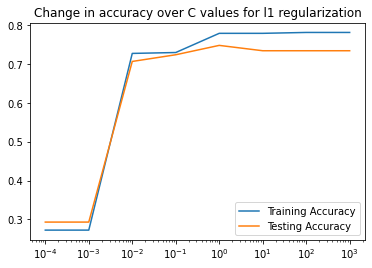

In [69]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(preprocessor, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

- According to this graph we get the best accuracy on the test set when C=1. The accuracy is 0.748. The accuracy on our test set after L1 tuning is slightly better than our default model whose test set accuracy is 0.728.

**b) L2 Tuning**

{0.0001: 0.7137931034482758,
 0.001: 0.7137931034482758,
 0.01: 0.7275862068965517,
 0.1: 0.7241379310344828,
 1: 0.7310344827586207,
 10: 0.7344827586206897,
 100: 0.7344827586206897,
 1000: 0.7344827586206897}

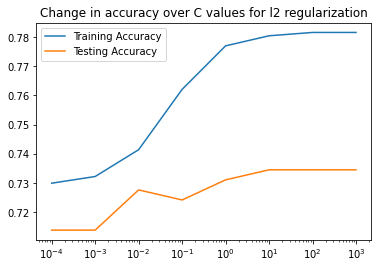

In [70]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_pipe = make_pipeline(preprocessor, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
  
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}


- According to this graph, we get the best accuracy on the test set when C=10. This is the same accuracy when C= 100 and C=1000. The accuracy is 0.734. The accuracy on our test set after L2 tuning is better than our default model but not as good as the accuracy after L1 tuning. The test set accuracy of our default model is 0.728.

We can see that our L1 tuned logistic regression model works best with a C value of 1.0.

**c) Confusion Matrices**

- We will use C value of 1

In [71]:
# Make an instance of the model
logregC = LogisticRegression(C = 1)
# Create and fit pipeline
logregC_pipe = make_pipeline(preprocessor, logreg)
# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y 
logregC_pipe.fit(X_train, y_train)
# Save predictions 
logregC_train_predictions = logreg_pipe.predict(X_train)
logregC_test_predictions = logreg_pipe.predict(X_test)

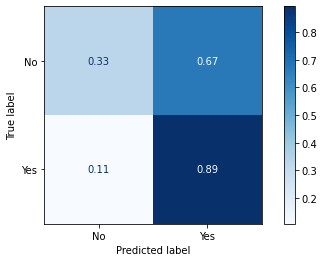

In [72]:
# "The following Code ("fig, ax") adapted from: https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81"
fig, ax = plt.subplots(figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_test, logregC_test_predictions, cmap = 'Blues',  normalize = 'true', ax=ax)

Our optimized logistic regression model correctly classified 89% of the samples in our test set that were class '**Yes**' (representing employee teams that met or exceeded their target productivity), and 33% of the samples in our test set that were class '**No**' (employee teams that did not meet or exceed their target productivity).

## **SMOTE** (Logistic Regression)

In [73]:
from imblearn.over_sampling import SMOTE, SMOTENC

In [74]:
pd.Series(y_train).value_counts()

Yes    633
No     237
Name: met_goal, dtype: int64

In [75]:
smote = SMOTE(sampling_strategy = 'auto')

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
pd.Series(y_train_smote).value_counts()

Yes    633
No     633
Name: met_goal, dtype: int64

In [76]:
smote_logreg = LogisticRegression(max_iter = 1000)
smote_logreg.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000)

In [77]:
# Save predictions 
smote_logreg_train_predictions = smote_logreg.predict(X_train_smote)
smote_logreg_test_predictions = smote_logreg.predict(X_test_processed)

In [78]:
# Run a classification report on both train and test datasets.
print('Training Metrics')
print(classification_report(y_train_smote, smote_logreg_train_predictions, digits = 4))
print('\nTesting Metrics')
print(classification_report(y_test, smote_logreg_test_predictions, digits = 4))

Training Metrics
              precision    recall  f1-score   support

          No     0.7489    0.8009    0.7740       633
         Yes     0.7861    0.7314    0.7578       633

    accuracy                         0.7662      1266
   macro avg     0.7675    0.7662    0.7659      1266
weighted avg     0.7675    0.7662    0.7659      1266


Testing Metrics
              precision    recall  f1-score   support

          No     0.4876    0.6941    0.5728        85
         Yes     0.8462    0.6976    0.7647       205

    accuracy                         0.6966       290
   macro avg     0.6669    0.6958    0.6688       290
weighted avg     0.7411    0.6966    0.7085       290



**a) L1 Tuning**

{0.0001: 0.29310344827586204,
 0.001: 0.29310344827586204,
 0.01: 0.5793103448275863,
 0.1: 0.6517241379310345,
 1: 0.696551724137931,
 10: 0.696551724137931,
 100: 0.7,
 1000: 0.7}

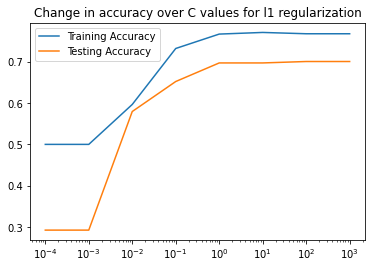

In [79]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  smote_logreg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  smote_logreg.fit(X_train_smote, y_train_smote)
 
  # add the training and testing scores to our scores lists
  train_scores.append(smote_logreg.score(X_train_smote, y_train_smote))
  test_scores.append(smote_logreg.score(X_test_processed, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

- According to this graph we get the best accuracy on the test set when C=100. We get this same accuracy when C=1000. The accuracy is 0.7. The accuracy on our test set after L1 tuning is approximately the same as our default SMOTE model whose test set accuracy is 0.6966.

**b) L2 Tuning**

{0.0001: 0.6517241379310345,
 0.001: 0.6482758620689655,
 0.01: 0.6482758620689655,
 0.1: 0.6862068965517242,
 1: 0.696551724137931,
 10: 0.7,
 100: 0.7,
 1000: 0.7}

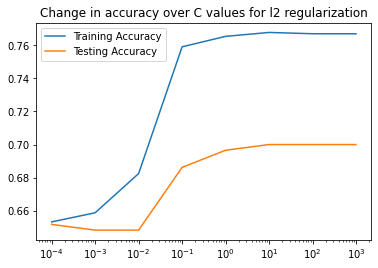

In [80]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
  # instantiate a model with each value of c and fit it on the data
  smote_logreg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  smote_logreg.fit(X_train_smote, y_train_smote)
 
  # add the training and testing scores to our scores lists
  train_scores.append(smote_logreg.score(X_train_smote, y_train_smote))
  test_scores.append(smote_logreg.score(X_test_processed, y_test))
  
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}


- According to this graph we get the best accuracy on the test set when C=10. We get this same accuracy when C=100 and C=1000. The accuracy is 0.7. The accuracy on our test set after L2 tuning is approximately the same as the accuracy our default SMOTE model and the same as the accuracy after L1 tuning. The test set accuracy of our default SMOTE model is 0.6966.

We can use C=10 for the confusion matrix.

**c) Confusion Matrices**

- We will use C value of 10

In [81]:
# Make an instance of the model
smote_logregC = LogisticRegression(C = 10)
# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y 
smote_logregC.fit(X_train_smote, y_train_smote)
# Save predictions 
smotelogregC_train_predictions = smote_logregC.predict(X_train_smote)
smotelogregC_test_predictions = smote_logregC.predict(X_test_processed)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


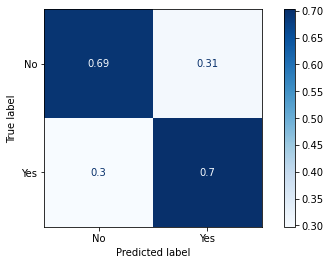

In [82]:
# "The following Code ("fig, ax") adapted from: https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81"
fig, ax = plt.subplots(figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_test, smotelogregC_test_predictions, cmap = 'Blues',  normalize = 'true', ax=ax)

Our SMOTE logistic regression model successfully classified 70% of the samples in our test set that were class '**Yes**' (representing employee teams that met or exceeded their target productivity), and 69% of the samples in our test set that were class '**No**' (employee teams that did not meet or exceed their target productivity).

## 20) KNN

In [86]:
#Create a pipeline with the preprocessed data (preprocessor) and a KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn_pipe = make_pipeline(preprocessor, knn)
#Fit KNN model pipeline and save predictions test set
knn_pipe.fit(X_train, y_train)
knn_train_predictions = knn_pipe.predict(X_train)
knn_test_predictions = knn_pipe.predict(X_test)

In [87]:
# Run a classification report on both train and test datasets.
print('Training Metrics')
print(classification_report(y_train, knn_train_predictions, digits = 4))
print('\nTesting Metrics')
print(classification_report(y_test, knn_test_predictions, digits = 4))

Training Metrics
              precision    recall  f1-score   support

          No     1.0000    1.0000    1.0000       237
         Yes     1.0000    1.0000    1.0000       633

    accuracy                         1.0000       870
   macro avg     1.0000    1.0000    1.0000       870
weighted avg     1.0000    1.0000    1.0000       870


Testing Metrics
              precision    recall  f1-score   support

          No     0.6389    0.5412    0.5860        85
         Yes     0.8211    0.8732    0.8463       205

    accuracy                         0.7759       290
   macro avg     0.7300    0.7072    0.7162       290
weighted avg     0.7677    0.7759    0.7700       290



- The results from the default KNN model are not good. The model did much better on the training set than the test set. This means the model is overfit. The accuracy, recall, precision and F1 scores were not very good on the testing set. Let's see if we can improve results on the testing set by tuning hyperparameters.

**a) GridSearchCV**

In [88]:
knn_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12c610>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12cc50>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__ca

In [89]:
#Parameters to tune
params = {'kneighborsclassifier__n_neighbors': range(1, 20),
          'kneighborsclassifier__weights': ['uniform', 'distance'],
          'kneighborsclassifier__p': [2, 3, 4]}

In [90]:
# Instantiate a gridsearch with the KNN model and the hyperparamter dictionary
knn_grid = GridSearchCV(knn_pipe, params)
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12c610>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12cc50>)])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 20),
                         'kneighborsclassifier__p': [2, 3, 4],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [91]:
# Check the optimal combinations of hyperparameters
knn_grid.best_params_

{'kneighborsclassifier__n_neighbors': 12,
 'kneighborsclassifier__p': 4,
 'kneighborsclassifier__weights': 'uniform'}

In [92]:
# extract the best version of the model from the gridsearch object
best_knn = knn_grid.best_estimator_

In [93]:
# Run a classification report on both train and test datasets for the best model. 
train_preds = best_knn.predict(X_train)
test_preds = best_knn.predict(X_test)

print('Best Model Training Metrics')
print(classification_report(y_train, train_preds, digits = 4))
print('\nBest Model Testing Metrics')
print(classification_report(y_test, test_preds, digits = 4))

Best Model Training Metrics
              precision    recall  f1-score   support

          No     0.7267    0.5274    0.6112       237
         Yes     0.8395    0.9258    0.8805       633

    accuracy                         0.8172       870
   macro avg     0.7831    0.7266    0.7459       870
weighted avg     0.8088    0.8172    0.8072       870


Best Model Testing Metrics
              precision    recall  f1-score   support

          No     0.6508    0.4824    0.5541        85
         Yes     0.8062    0.8927    0.8472       205

    accuracy                         0.7724       290
   macro avg     0.7285    0.6875    0.7006       290
weighted avg     0.7606    0.7724    0.7613       290



- We can see from the above results that tuning our KNN model did not improve results for our testing set. The accuracy is lower in the tuned model than the default model. However, there is much less overfitting.

**b) Confusion Matrices**

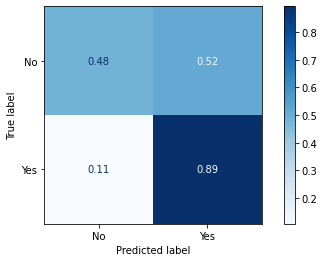

In [94]:
# "The following Code ("fig, ax") adapted from: https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81"
fig, ax = plt.subplots(figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap = 'Blues',  normalize = 'true', ax=ax)

Our optimized KNN model successfully classified 89% of the samples in our test set that were class 'Yes' (representing employee teams that met or exceeded their target productivity), and 39% of the samples in our test set that were class 'No' (representing employee teams that did not meet or exceed their target productivity).

## **SMOTE** (KNN)

In [95]:
pd.Series(y_train).value_counts()

Yes    633
No     237
Name: met_goal, dtype: int64

In [96]:
smote = SMOTE(sampling_strategy = 'auto')

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
pd.Series(y_train_smote).value_counts()

Yes    633
No     633
Name: met_goal, dtype: int64

In [97]:
smote_KNN = KNeighborsClassifier(n_neighbors=1)
smote_KNN.fit(X_train_smote, y_train_smote)

KNeighborsClassifier(n_neighbors=1)

In [98]:
# Save predictions 
smote_KNN_train_predictions = smote_KNN.predict(X_train_smote)
smote_KNN_test_predictions = smote_KNN.predict(X_test_processed)

In [99]:
# Run a classification report on both train and test datasets.
print('Training Metrics')
print(classification_report(y_train_smote, smote_KNN_train_predictions, digits = 4))
print('\nTesting Metrics')
print(classification_report(y_test, smote_KNN_test_predictions, digits = 4))

Training Metrics
              precision    recall  f1-score   support

          No     1.0000    1.0000    1.0000       633
         Yes     1.0000    1.0000    1.0000       633

    accuracy                         1.0000      1266
   macro avg     1.0000    1.0000    1.0000      1266
weighted avg     1.0000    1.0000    1.0000      1266


Testing Metrics
              precision    recall  f1-score   support

          No     0.5096    0.6235    0.5608        85
         Yes     0.8280    0.7512    0.7877       205

    accuracy                         0.7138       290
   macro avg     0.6688    0.6874    0.6743       290
weighted avg     0.7346    0.7138    0.7212       290



In [100]:
smote_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [101]:
#Parameters to tune
smote_params = {'n_neighbors': range(1, 20),
          'weights': ['uniform', 'distance'],
          'p': [2, 3, 4]}

In [102]:
# Instantiate a gridsearch with the KNN model and the hyperparamter dictionary
smote_knn_grid = GridSearchCV(smote_KNN, smote_params)
smote_knn_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=1),
             param_grid={'n_neighbors': range(1, 20), 'p': [2, 3, 4],
                         'weights': ['uniform', 'distance']})

In [103]:
smote_knn_grid.best_params_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [104]:
# extract the best version of the model from the gridsearch object
best_smote_knn = smote_knn_grid.best_estimator_

In [105]:
# Run a classification report on both train and test datasets for the best model. 
smote_KNN_train_preds = best_smote_knn.predict(X_train_smote)
smote_KNN_test_preds = best_smote_knn.predict(X_test_processed)

print('Best Model Training Metrics')
print(classification_report(y_train_smote, smote_KNN_train_preds, digits = 4))
print('\nBest Model Testing Metrics')
print(classification_report(y_test, smote_KNN_test_preds, digits = 4))

Best Model Training Metrics
              precision    recall  f1-score   support

          No     1.0000    1.0000    1.0000       633
         Yes     1.0000    1.0000    1.0000       633

    accuracy                         1.0000      1266
   macro avg     1.0000    1.0000    1.0000      1266
weighted avg     1.0000    1.0000    1.0000      1266


Best Model Testing Metrics
              precision    recall  f1-score   support

          No     0.5096    0.6235    0.5608        85
         Yes     0.8280    0.7512    0.7877       205

    accuracy                         0.7138       290
   macro avg     0.6688    0.6874    0.6743       290
weighted avg     0.7346    0.7138    0.7212       290



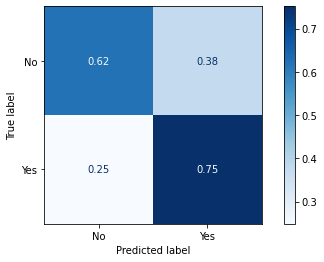

In [106]:
# "The following Code ("fig, ax") adapted from: https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81"
fig, ax = plt.subplots(figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_test, smote_KNN_test_preds, cmap = 'Blues',  normalize = 'true', ax=ax)

## 21. Random Forest Model

In [107]:
#Create a pipeline with the preprocessed data (preprocessor) and RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
#Fit Random Forest model pipeline and save predictions test set
rf_pipe.fit(X_train, y_train)
rf_train_predictions = rf_pipe.predict(X_train)
rf_test_predictions = rf_pipe.predict(X_test)

In [108]:
# Run a classification report on both train and test datasets.
print('Training Metrics')
print(classification_report(y_train, rf_train_predictions, digits = 4))
print('\nTesting Metrics')
print(classification_report(y_test, rf_test_predictions, digits = 4))

Training Metrics
              precision    recall  f1-score   support

          No     1.0000    1.0000    1.0000       237
         Yes     1.0000    1.0000    1.0000       633

    accuracy                         1.0000       870
   macro avg     1.0000    1.0000    1.0000       870
weighted avg     1.0000    1.0000    1.0000       870


Testing Metrics
              precision    recall  f1-score   support

          No     0.7246    0.5882    0.6494        85
         Yes     0.8416    0.9073    0.8732       205

    accuracy                         0.8138       290
   macro avg     0.7831    0.7478    0.7613       290
weighted avg     0.8073    0.8138    0.8076       290



- The results from the default Random Forest model are not very good. The model did much better on the training set than the test set. This means the model is overfit. The accuracy, recall, precision and F1 scores were not very good on the testing set. Let's see if we can improve results on the testing set by tuning hyperparameters. 

**a) GridSearchCV**

In [109]:
rf_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12c610>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12cc50>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'columntransformer__onehotencoder__ca

In [110]:
#Parameters to tune
rf_params = {'randomforestclassifier__max_depth' : [None, 5],
             'randomforestclassifier__n_estimators' : [100, 300, 500],
             'randomforestclassifier__min_samples_split' : [2, 4]}

In [111]:
# Instantiate a gridsearch with the Random Forest model and the hyperparameter dictionary
rf_grid = GridSearchCV(rf_pipe, rf_params)
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12c610>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f025d12cc50>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 5],
                         'randomforestclassifier__min_samples_split': [2, 4],
                         'randomforestclassifier__n_estimators': [100, 300,
                                                                  500]})

In [112]:
# Check the optimal combinations of hyperparameters
rf_grid.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 300}

In [113]:
# extract the best version of the model from the gridsearch object
best_rf = rf_grid.best_estimator_

In [114]:
# Run a classification report on both train and test datasets for the best model. 
train_rf_preds = best_rf.predict(X_train)
test_rf_preds = best_rf.predict(X_test)

print('Best Model Training Metrics')
print(classification_report(y_train, train_rf_preds, digits = 4))
print('\nBest Model Testing Metrics')
print(classification_report(y_test, test_rf_preds, digits = 4))

Best Model Training Metrics
              precision    recall  f1-score   support

          No     0.9870    0.9578    0.9722       237
         Yes     0.9844    0.9953    0.9898       633

    accuracy                         0.9851       870
   macro avg     0.9857    0.9765    0.9810       870
weighted avg     0.9851    0.9851    0.9850       870


Best Model Testing Metrics
              precision    recall  f1-score   support

          No     0.7143    0.5882    0.6452        85
         Yes     0.8409    0.9024    0.8706       205

    accuracy                         0.8103       290
   macro avg     0.7776    0.7453    0.7579       290
weighted avg     0.8038    0.8103    0.8045       290



- We can see from the above results that tuning our Random Forest model did not really improve our results. The testing scores are approximately the same or slightly lower. This model is still overfit. The overfitting was only reduced slightly as well.

**b) Confusion Matrices**

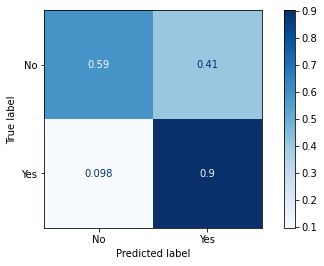

In [115]:
# "The following Code ("fig, ax") adapted from: https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81"
fig, ax = plt.subplots(figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_test, test_rf_preds, cmap = 'Blues',  normalize = 'true', ax=ax)

Our optimized Random Forest model correctly classified 90% of the samples in our test set that were class 'Yes' (representing employee teams that met or exceeded their target productivity), and 59% of the samples in our test set that were class 'No' (representing employee teams that did not meet or exceed their target productivity).

## **SMOTE** (Random Forest)

In [181]:
pd.Series(y_train).value_counts()

Yes    633
No     237
Name: met_goal, dtype: int64

In [182]:
smote = SMOTE(sampling_strategy = 'auto')

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
pd.Series(y_train_smote).value_counts()

Yes    633
No     633
Name: met_goal, dtype: int64

In [183]:
smote_RF = RandomForestClassifier(random_state = 42)
smote_RF.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [184]:
# Save predictions 
smote_RF_train_predictions = smote_RF.predict(X_train_smote)
smote_RF_test_predictions = smote_RF.predict(X_test_processed)

In [185]:
# Run a classification report on both train and test datasets.
print('Training Metrics')
print(classification_report(y_train_smote, smote_RF_train_predictions, digits = 4))
print('\nTesting Metrics')
print(classification_report(y_test, smote_RF_test_predictions, digits = 4))

Training Metrics
              precision    recall  f1-score   support

          No     1.0000    1.0000    1.0000       633
         Yes     1.0000    1.0000    1.0000       633

    accuracy                         1.0000      1266
   macro avg     1.0000    1.0000    1.0000      1266
weighted avg     1.0000    1.0000    1.0000      1266


Testing Metrics
              precision    recall  f1-score   support

          No     0.6829    0.6588    0.6707        85
         Yes     0.8606    0.8732    0.8668       205

    accuracy                         0.8103       290
   macro avg     0.7718    0.7660    0.7687       290
weighted avg     0.8085    0.8103    0.8093       290



In [186]:
smote_RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [187]:
#Parameters to tune
rfsmote_params = {'max_depth' : [None, 5],
             'n_estimators' : [100, 300, 500],
             'min_samples_split' : [2, 4]}

In [188]:
# Instantiate a gridsearch with the KNN model and the hyperparamter dictionary
smote_RF_grid = GridSearchCV(smote_RF, rfsmote_params)
smote_RF_grid.fit(X_train_smote, y_train_smote)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5], 'min_samples_split': [2, 4],
                         'n_estimators': [100, 300, 500]})

In [189]:
smote_RF_grid.best_params_

{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 500}

In [190]:
# extract the best version of the model from the gridsearch object
best_smote_RF = smote_RF_grid.best_estimator_

In [191]:
# Run a classification report on both train and test datasets for the best model. 
smote_RF_train_preds = best_smote_RF.predict(X_train_smote)
smote_RF_test_preds = best_smote_RF.predict(X_test_processed)

print('Best Model Training Metrics')
print(classification_report(y_train_smote, smote_RF_train_preds, digits = 4))
print('\nBest Model Testing Metrics')
print(classification_report(y_test, smote_RF_test_preds, digits = 4))

Best Model Training Metrics
              precision    recall  f1-score   support

          No     0.9953    0.9968    0.9961       633
         Yes     0.9968    0.9953    0.9960       633

    accuracy                         0.9961      1266
   macro avg     0.9961    0.9961    0.9961      1266
weighted avg     0.9961    0.9961    0.9961      1266


Best Model Testing Metrics
              precision    recall  f1-score   support

          No     0.7024    0.6941    0.6982        85
         Yes     0.8738    0.8780    0.8759       205

    accuracy                         0.8241       290
   macro avg     0.7881    0.7861    0.7871       290
weighted avg     0.8235    0.8241    0.8238       290



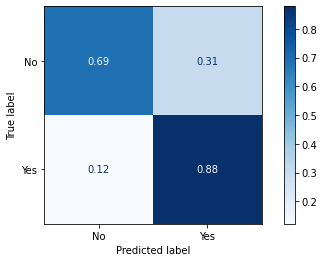

In [192]:
# "The following Code ("fig, ax") adapted from: https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81"
fig, ax = plt.subplots(figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_test, smote_RF_test_preds, cmap = 'Blues',  normalize = 'true', ax=ax)

## 22. Choose one final model.

- All the models had some level of overfitting. The accuracy scores for all models were not that great, but were not terrible either.

- Considering the target classes were imbalanced, a data augmentation technique had to be applied that synthesizes new examples from the minority class (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). The name of this technique is "Synthetic Minority Oversampling TEchnique (SMOTE)." 

- I have chosen the optimized Random Forest (SMOTE) model because it's the model with the least overfitting of all the models where SMOTE was applied. It's training accuracy score was 0.9961 and its testing accuracy score was 0.8241. 

- Also, based on the confusion matrices, the Random Forest (SMOTE) model had the highest percentage of True Positives and True Negatives of all models where SMOTE was applied when it came to identifying employee teams that met or did not meet their target productivty, which is important for this problem. The Random Forest model was able to correctly classify 88% of the samples in our test set that were 'Yes' (representing employee teams that met or exceeded their target productivity). It was able to classify 69% of the samples in our test set that were 'No' (representing employee teams that did not meet their target productivity). 

- As a result of the above reasons, I would choose the Random Forest model.